# Loan Dataset Machine Learning Practice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_encoded = pd.read_csv("datasets/loan_encoded.csv")
df_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,...,Loan_Amount_Term_60.0,Loan_Amount_Term_84.0,Loan_Amount_Term_120.0,Loan_Amount_Term_180.0,Loan_Amount_Term_240.0,Loan_Amount_Term_300.0,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Loan_Status_N,Loan_Status_Y
0,0.497164,-0.874587,0.150494,False,True,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
1,-0.013767,0.054395,-0.179896,False,True,False,True,False,True,False,...,False,False,False,False,False,False,True,False,True,False
2,-0.652632,-0.874587,-1.292433,False,True,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,-0.820924,0.578025,-0.323449,False,True,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,True
4,0.558104,-0.874587,0.053377,False,True,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True


### Revert Scaling Test

In [3]:
import joblib
scaler = joblib.load('scaler/scaler.pkl')

In [4]:
# These are 3 columns that we scaled in the previous project
scaled_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

df_original = df_encoded.copy()
df_original[scaled_cols] = scaler.inverse_transform(df_encoded[scaled_cols])
df_original.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,...,Loan_Amount_Term_60.0,Loan_Amount_Term_84.0,Loan_Amount_Term_120.0,Loan_Amount_Term_180.0,Loan_Amount_Term_240.0,Loan_Amount_Term_300.0,Loan_Amount_Term_360.0,Loan_Amount_Term_480.0,Loan_Status_N,Loan_Status_Y
0,5849.0,0.0,146.412162,False,True,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
1,4583.0,1508.0,128.000000,False,True,False,True,False,True,False,...,False,False,False,False,False,False,True,False,True,False
2,3000.0,0.0,66.000000,False,True,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,2583.0,2358.0,120.000000,False,True,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,True
4,6000.0,0.0,141.000000,False,True,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True


### Based on the reference from 
https://github.com/MomorioUHT/Data-Cleaning-Preprocessing/blob/main/Loan-preprocessing.ipynb<br/>
the data after inverse scaling is correct!<br/>
(but we will still use the 'df_encoded' for the machine learning)

### Imports for essential libraries

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

### Train test splitting

In [6]:
X = df_encoded.drop(["Loan_Status_N", "Loan_Status_Y"], axis=1)
y = np.where(df_encoded["Loan_Status_Y"], 1, 0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### See the amount of class 0s and 1s

In [8]:
pd.Series(y).value_counts()

1    422
0    192
Name: count, dtype: int64

In [9]:
pd.Series(y).value_counts(normalize=True)

1    0.687296
0    0.312704
Name: proportion, dtype: float64

## Attempt #1 DecisionTreeClassifier

| พารามิเตอร์             | ความหมาย                                                | ค่าที่ลอง                         | คำอธิบายเพิ่มเติม                                                                                                                                                                                                                                                      |
| ----------------------- | ------------------------------------------------------- | --------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`criterion`**         | วิธีวัด “ความบริสุทธิ์” ของโหนด (node impurity)         | `["gini", "entropy", "log_loss"]` | <ul><li>`gini` → วัดความบริสุทธิ์แบบ Gini Index (ค่าเริ่มต้น, คำนวณเร็ว)</li><li>`entropy` → ใช้สูตร Shannon Entropy (ค่ามาก = ข้อมูลหลากหลาย)</li><li>`log_loss` → ใช้ log loss (คล้าย entropy แต่ใช้ค่า probability ตรงกว่า เหมาะกับ probabilistic output)</li></ul> |
| **`max_depth`**         | ความลึกสูงสุดของต้นไม้                                  | `[3, 5, 7, 10, None]`             | <ul><li>จำกัดระดับความลึกของต้นไม้ เพื่อควบคุม overfitting</li><li>ค่าต่ำ → โมเดลเรียบ bias สูง</li><li>ค่า `None` → สร้างจนกว่าจะบริสุทธิ์ทุกใบ (เสี่ยง overfit)</li></ul>                                                                                            |
| **`min_samples_split`** | จำนวนตัวอย่างขั้นต่ำที่ต้องมีเพื่อ “แยกโหนด”            | `[2, 5, 10, 20]`                  | <ul><li>ค่ามาก → ต้นไม้แตกน้อยลง (generalize ดีขึ้น)</li><li>ค่าต่ำ → แตกง่าย อาจ overfit</li></ul>                                                                                                                                                                    |
| **`min_samples_leaf`**  | จำนวนตัวอย่างขั้นต่ำที่ต้องมีใน “ใบ” (leaf node)        | `[1, 2, 4, 8]`                    | <ul><li>ควบคุมไม่ให้ใบเล็กเกินไป</li><li>ค่ามาก → ใบใหญ่ขึ้น โมเดลเรียบขึ้น</li></ul>                                                                                                                                                                                  |
| **`max_features`**      | จำนวน feature สูงสุดที่อนุญาตให้พิจารณาในแต่ละการ split | `["sqrt", "log2", None]`          | <ul><li>`sqrt` → ใช้รากที่สองของจำนวน feature (เหมาะกับ classification)</li><li>`log2` → ใช้ log₂(n_features)</li><li>`None` → ใช้ทุก feature (อาจ overfit)</li></ul>                                                                                                  |


In [10]:
from sklearn.tree import DecisionTreeClassifier

dtreeclassifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "max_features": ["sqrt", "log2", None],
}

grid_seach_dtc = GridSearchCV(
    estimator=dtreeclassifier,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1, #Core
    verbose=1
)

grid_seach_dtc.fit(X_train, y_train)

dtc_model = grid_seach_dtc.best_estimator_

print("Best parameters:", grid_seach_dtc.best_params_)
print("Best score:", grid_seach_dtc.best_score_)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}
Best score: 0.7943104514533086


### Attempt #2 Logistic Regression

| พารามิเตอร์    | ความหมาย                                            | ค่าที่ลอง                      | คำอธิบายเพิ่มเติม                                                                                                                                                                                                |
| -------------- | --------------------------------------------------- | ------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`penalty`**  | วิธีควบคุมความซับซ้อนของโมเดล (Regularization)      | `'l1'`, `'l2'`, `'elasticnet'` | <ul><li>`l1` → ทำให้บางค่าน้ำหนักเป็น 0 → เหมาะกับการเลือก feature (Feature Selection)</li><li>`l2` → ลดค่าน้ำหนักแต่ไม่ให้เป็นศูนย์ → ป้องกัน overfitting</li><li>`elasticnet` → ผสมระหว่าง L1 และ L2</li></ul> |
| **`C`**        | ค่ากลับของ strength ของ regularization (λ = 1/C)    | `[0.001, 0.01, 0.1, 1, 10]`    | <ul><li>ค่าน้อย → บังคับโมเดลให้เรียบ (strong regularization)</li><li>ค่ามาก → โมเดลยืดหยุ่นมากขึ้น (weak regularization)</li></ul>                                                                              |
| **`solver`**   | อัลกอริธึมที่ใช้หาคำตอบของสมการ Logistic Regression | `'liblinear'`, `'saga'`        | <ul><li>`liblinear` → เร็ว เหมาะกับข้อมูลขนาดเล็ก (ใช้ได้กับ L1/L2 เท่านั้น)</li><li>`saga` → รองรับ elasticnet ได้ และเหมาะกับข้อมูลหลาย class หรือขนาดใหญ่</li></ul>                                           |
| **`l1_ratio`** | สัดส่วนของ L1 ใน Elastic Net                        | `[0, 0.5, 1]`                  | <ul><li>ใช้เฉพาะเมื่อ `penalty='elasticnet'`</li><li>`0` = ใช้ L2 ล้วน</li><li>`1` = ใช้ L1 ล้วน</li><li>`0.5` = ผสม L1 กับ L2 อย่างละครึ่ง</li></ul>                                                            |
| **`max_iter`** | จำนวนรอบสูงสุดในการทำ optimization                  | `[500, 1000]`                  | <ul><li>ใช้ควบคุมให้โมเดลเรียนรู้จนกว่าจะ converge</li><li>ค่ามากขึ้น = ใช้เวลามากขึ้น แต่ป้องกันปัญหาไม่ converge</li></ul>                                                                                     |


In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['liblinear'],
        'max_iter': [500, 750]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10],
        'solver': ['saga'],
        'l1_ratio': [0, 0.5, 1],
        'max_iter': [500, 750]
    }
]

grid_seach_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1, #Core
    verbose=0
)

grid_seach_lr.fit(X_train, y_train)

lr_model = grid_seach_lr.best_estimator_

print("Best parameters:", grid_seach_lr.best_params_)
print("Best score:", grid_seach_lr.best_score_)

c:\Users\momoriouht\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\momoriouht\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.7983714698000413


### Attempt #3 RandomForestClassifier

| พารามิเตอร์             | ค่าที่ลอง                         | ความหมาย                                                                                                                                                                                                               |
| ----------------------- | --------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`n_estimators`**      | `[50, 100]`                  | จำนวนต้นไม้ (trees) ใน forest — ยิ่งมากมักให้ผลลัพธ์แม่นขึ้นแต่ใช้เวลาเทรนมากขึ้น                                                                                                                                      |
| **`criterion`**         | `["gini", "entropy"]` | เกณฑ์วัดความบริสุทธิ์ของการแบ่ง node <br>• `gini` → ค่าเริ่มต้น, เร็วและเสถียร <br>• `entropy` → ใช้ข้อมูลเชิง log, แม่นขึ้นเล็กน้อยแต่ช้ากว่า <br> |
| **`max_depth`**         | `[5, 10, None]`             | ความลึกสูงสุดของแต่ละต้นไม้ <br>• ค่าน้อย → ป้องกัน overfitting <br>• `None` → ให้แตกจนกว่าทุก leaf บริสุทธิ์ (มัก overfit ถ้าข้อมูลน้อย)                                                                              |
| **`min_samples_split`** | `[2, 10]`                      | จำนวนข้อมูลขั้นต่ำก่อนจะแบ่ง node ใหม่ <br>• ค่าน้อย → แตก node ได้ง่าย <br>• ค่ามาก → ทำให้โมเดลทั่วไปขึ้น (regularize)                                                                                               |
| **`min_samples_leaf`**  | `[1, 4]`                       | จำนวนข้อมูลขั้นต่ำในแต่ละ leaf <br>• ค่าน้อย → โมเดลเรียนรู้ละเอียด <br>• ค่ามาก → ป้องกัน noise                                                                                                                       |
| **`max_features`**      | `["sqrt", "log2"]`          | จำนวน feature ที่จะสุ่มใช้ในแต่ละ split <br>• `"sqrt"` → ดีสำหรับ classification <br>• `"log2"` → เลือกน้อยลงอีก (เร็วขึ้น)                                              |
| **`bootstrap`**         | `[True, False]`                   | จะสุ่มข้อมูลซ้ำ (bootstrap sampling) หรือไม่ <br>• `True` → ค่าเริ่มต้นของ RandomForest, ให้ผลดีทั่วไป <br>• `False` → ใช้ข้อมูลทั้งหมดทุกต้น (เร็วขึ้นแต่เสี่ยง overfit)                                              |


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=1,
)

grid_search_rf.fit(X_train, y_train)

rf_model = grid_search_rf.best_estimator_

print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.8004122861265719


### Attempt #4 GradientBoostingClassifier

| พารามิเตอร์             | ค่าที่ใช้                | ความหมาย                                                                                                                             |
| ----------------------- | ------------------------ | ------------------------------------------------------------------------------------------------------------------------------------ |
| **`n_estimators`**      | `[50, 100]`         | จำนวนต้นไม้ใน gradient boosting (เพิ่มมาก → โมเดลแม่นขึ้นแต่รันช้า)                                                                  |
| **`learning_rate`**     | `[0.05, 0.1]`      | ขนาด step ของแต่ละ tree ที่เพิ่มเข้าโมเดล <br>• ค่าน้อย → เพิ่ม trees ต้องมากขึ้น แต่ generalize ดี                                  |
| **`max_depth`**         | `[3, 5]`              | ความลึกสูงสุดของแต่ละ tree <br>• ค่าน้อย → ป้องกัน overfitting                                                                       |
| **`min_samples_split`** | `[2, 10]`             | จำนวนตัวอย่างขั้นต่ำก่อนจะแบ่ง node <br>• ค่ามาก → node แตกยาก → ลด overfitting                                                      |
| **`min_samples_leaf`**  | `[1, 4]`              | จำนวนตัวอย่างขั้นต่ำใน leaf <br>• ป้องกัน leaf เล็กเกินไปที่ overfit ข้อมูล                                                          |
| **`subsample`**         | `[0.85, 1.0]`       | สัดส่วนข้อมูลที่สุ่มใช้ในแต่ละ tree <br>• <1 → ช่วย regularization ลด overfitting                                                    |
| **`max_features`**      | `["sqrt", "log2"]` | จำนวน feature ที่สุ่มใช้แต่ละ split <br>• `"sqrt"` → ปรับตามจำนวน features √n <br>• `"log2"` → log₂(n)


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)

param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "subsample": [0.85, 1.0],
    "max_features": ["sqrt", "log2"],
}

grid_search_gbc = GridSearchCV(
    estimator=gbc,
    scoring='accuracy',
    param_grid=param_grid,
    cv=5,
    n_jobs=1,
    verbose=1,
)

grid_search_gbc.fit(X_train, y_train)

gbc_model = grid_search_gbc.best_estimator_

print(grid_search_gbc.best_params_)
print(grid_search_gbc.best_score_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 1.0}
0.7983714698000413


## Summary

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [15]:
models = {
    "Decision Tree Classifier": dtc_model,
    "Linear Regression": lr_model,
    "Random Forest Classifier": rf_model,
    "Gradient Boosting Classifier": gbc_model
}

### Model Accuracy Comparison

----------------------
DEBUG: Model type for Decision Tree Classifier: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Decision Tree Classifier
F1: 0.7955161369795516
Precision: 0.7991014120667522
Recall: 0.8048780487804879
----------------------
DEBUG: Model type for Linear Regression: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Linear Regression
F1: 0.8404405979543665
Precision: 0.8696406225988452
Recall: 0.8536585365853658
----------------------
DEBUG: Model type for Random Forest Classifier: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Random Forest Classifier
F1: 0.8404405979543665
Precision: 0.8696406225988452
Recall: 0.8536585365853658
----------------------
DEBUG: Model type for Gradient Boosting Classifier: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Gradient Boosting Classifier
F1: 0.8404405979543665
Precision: 0.8696406225988452
Recall: 0.8536585365853658


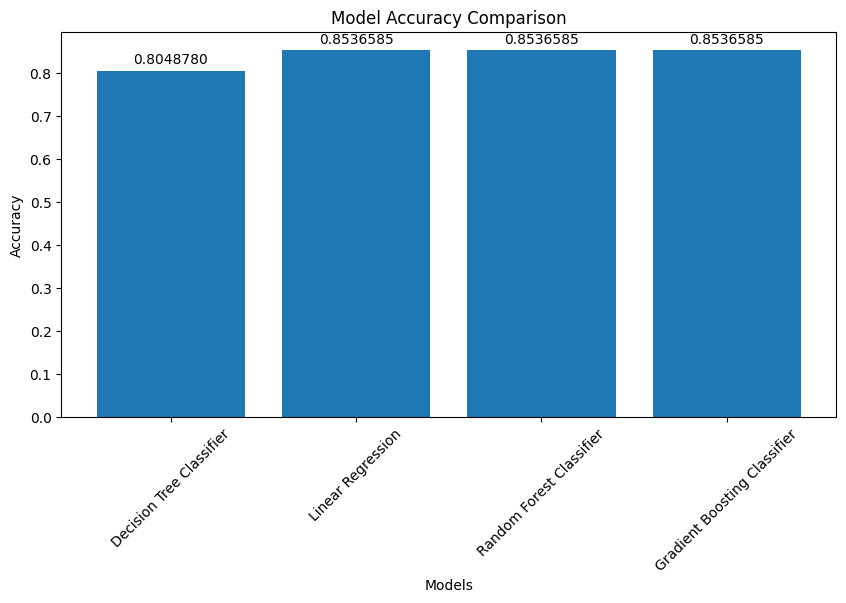

In [17]:
scores = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print("----------------------")
    print(f"DEBUG: Model type for {name}: {type(model)}")
    print(name)
    print("F1:", f1_score(y_test, y_pred, average='weighted'))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    scores[name] = accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Model Accuracy Comparison")
bars = ax.bar(
    scores.keys(),
    scores.values()
)
ax.bar_label(bars, labels=[f"{x:.7f}" for x in scores.values()], padding=3)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Models")
plt.xticks(rotation=45)
plt.show()

### Since there is about 600 Samples and has been scaled
การที่ผลลัพธ์ของ Logistic Regression และ Random Forest/Gradient Boosting เหมือนกัน
* Logistic Regression ได้ทำงานดีที่สุดแล้ว ในการหาขอบเขตการแบ่งแยกที่เกือบสมบูรณ์แบบ และข้อมูลไม่ได้มีรูปแบบที่ซับซ้อน (Non-linear Patterns)